In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (4, 3)
plt.rcParams['font.size'] = 8
plt.rcParams["figure.autolayout"] = True # same as tight_layout after every plot
from interface_1d import swi_simulate, swi_simulate_steady, fdfresh1d_step, fdsalt1d_step

In [2]:
# grid
L = 2000 # length of aquifer, m
Lcoast = 500
ncoast = 10 # number of cells to represent coast on left and right
ncol = 40 + 2 * ncoast #41 # number of columns
#ncol = 11
delx = (L + 2 * Lcoast) / ncol # computed cell size, m

# parameters
k = 10 # horizontal hydraulic conductivity, m/d
S = 0.2 # storage coefficient, -
Se = 1e-4 # specific storage coef, m^(-1)
zt = 0 * np.ones(ncol) # aquifer top, m
zb = -50 * np.ones(ncol) # aquifer bottom, m
rhof = 1000 # freshwater density, kg/m3
rhos = 1025 # saltwater density, kg/m3
hsea = 0 # head in sea (used in steady simulation), m
hstar = 0 # head in ghb cells, m
c = 100 # resistance of sea bottom, m

# bc
hleft = 0 # head on left side, m
hright = 0 # head on right side, m
fixed = None
#fixed = np.nan * np.ones(ncol) # array with fixed head values
#fixed[0] = hleft
#fixed[-1] = hright
N = 0.001 # recharge, m/d
#ghb = None
ghb = []
for icol in range(ncoast):
    ghb.append((icol, hstar, delx / c))
for icol in range(ncol - ncoast, ncol):
    ghb.append((icol, hstar, delx / c))

# initial conditions
hf0 = 0.001 # freshwater head in freshwater, m
zeta0 = -0.04 # interface, m

# time step
#delt = 4000 # time step, d
#delt = 100 # time step, d
#nstep = 20 # number of time steps
delt = 2000
nstep = 40
perlen = delt * nstep

# computed parameters
xg = np.arange(delx / 2, L + 2 * Lcoast, delx) - (L / 2 + Lcoast) # grid coordinates, m
Qf = np.zeros(ncol)
Qf[ncoast:-ncoast] = N * delx # array with source terms
Qs = np.zeros(ncol)
hfini = hf0 * np.ones(ncol) # array with initial freshwater head
zetaini = zeta0 * np.ones(ncol) # array with initial saltwater head

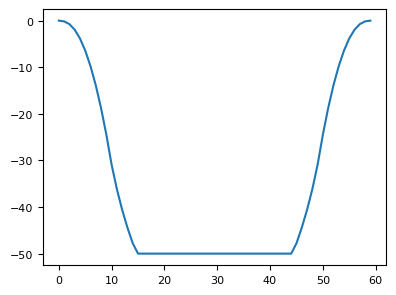

In [3]:
hf1, zeta1, _ = swi_simulate_steady(hfini, k, 0, 0, zb, zt, Qf, Qs, fixed, ghb, rhof, rhos, delx, hsea, perlen, 1, tmultiply=1)
plt.plot(zeta1[1])

In [4]:
# try starting with steady interface
hf1, zeta1, _ = swi_simulate_steady(hfini, k, S, Se, zb, zt, Qf, Qs, fixed, ghb, rhof, rhos, delx, hsea, perlen, nstep, tmultiply=1)

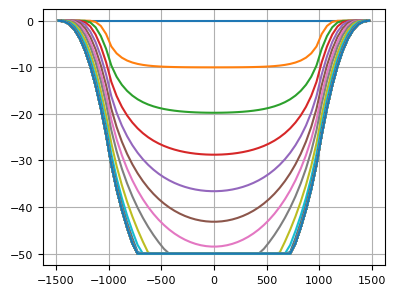

In [5]:
for i in range(nstep + 1):
    plt.plot(xg, zeta1[i])
plt.grid()

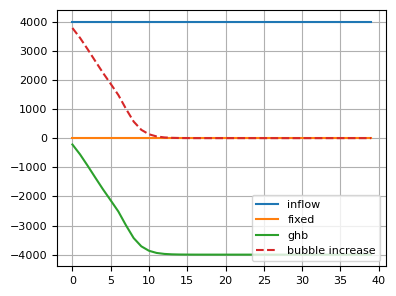

In [6]:
Qsource = np.zeros(nstep)
Qfixed = np.zeros(nstep)
Qghb = np.zeros(nstep)
storage_increase = np.zeros(nstep)
for i in range(nstep):
    Qso, Qfi, Qgh, st_in = fdfresh1d_step(hf1[i + 1], hf1[i], zeta1[i + 1], zeta1[i], k, S, Se, zb, zt, Qf, fixed, ghb, rhof, rhos,  
                       delx, delt, budget=True)
    Qsource[i], Qfixed[i], Qghb[i], storage_increase[i] = np.sum(Qso), np.sum(Qfi), np.sum(Qgh), np.sum(st_in)
#
plt.plot(Qsource, label='inflow')
plt.plot(Qfixed, label='fixed')
plt.plot(Qghb, label='ghb')
plt.plot(storage_increase, '--', label='bubble increase')
plt.legend(loc='lower right')
plt.grid()

In [7]:
Qsource + Qfixed + Qghb - storage_increase

array([-3.18323146e-12,  4.54747351e-13,  4.09272616e-12, -8.18545232e-12,
       -3.18323146e-11,  4.44889504e-05,  5.00589349e-05,  6.24967438e-05,
       -2.92175173e-11,  5.04201125e-11,  4.21209734e-11, -3.53423957e-11,
        8.28173086e-11, -7.73425768e-11,  4.00852684e-11,  2.09023909e-11,
       -7.57871543e-12,  4.06737422e-11,  7.02258807e-11,  4.15655704e-12,
       -1.86830725e-11,  3.98305937e-11,  1.26117424e-11,  1.12390327e-12,
       -1.11239385e-10,  1.10662481e-10,  3.37323911e-11,  1.85302895e-11,
       -7.17654521e-12,  4.15753903e-11, -3.36863230e-12,  4.24466149e-11,
        1.88098547e-11, -1.94122273e-11, -1.00769036e-11,  4.35861307e-11,
       -2.74891165e-11,  1.68187438e-11,  4.99311704e-13, -8.76691103e-11])

In [8]:
hf1, hs1, zeta1, t1 = swi_simulate(hfini, zetaini, k, S, Se, zb, zt, Qf, Qs, fixed, ghb, rhof, rhos, delx, perlen, nstep, tmultiply=1, maxiter=100)
#Qfreduced = 0.05 * Qf
#hf2, zeta2, t2 = swi_simulate(hf1[-1], zeta1[-1], k, S, Se, zb, Qfreduced, Qs, fixed, ghb, rhof, rhos, delx, perlen, nstep, tmultiply=1)

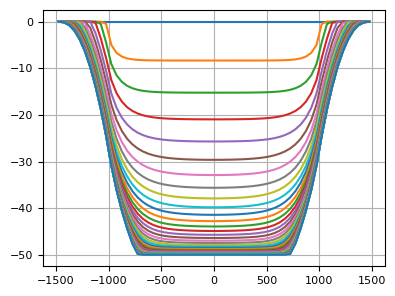

In [9]:
for i in range(nstep + 1):
    plt.plot(xg, zeta1[i])
plt.grid()

In [10]:
ighb = [g[0] for g in ghb]
ighb

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]